# Screened feasibility analysis

In [19]:
import easyvvuq as uq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path

In [24]:
print("Reading in campaign database.")

# Find DB
db_count = 0
for db_path in Path.cwd().glob("campaigns/*/campaign.db"):
    if db_count > 0:
        raise RuntimeError("More than one database in the campaigns dir")
    
    db_location = str(db_path.resolve())
    db_count += 1

# /// prefix is required before absolute path
db_location_prefixed = f"sqlite:///{db_location}"
campaign = uq.Campaign(db_location=db_location_prefixed, name="model_inputs", work_dir="campaigns")

samples = campaign.get_collation_result()
sample_count = samples.shape[0]
print(f"Campaign read in. Number of samples = {sample_count}")


Reading in campaign database.
Campaign read in. Number of samples = 256


In [3]:
# Drop strange multi-index of 0
samples.columns = samples.columns.droplevel(1)
# samples

## Analysis

Check out the QOIs from the samples.

In [4]:
qois = [
    "objf",
    "eq_1",
    "eq_2",
    "eq_11" ,
    "ineq_5",
    "ineq_8",
    "ineq_9",
    "ineq_13",
    "ineq_15",
    "ineq_30",
    "ineq_16",
    "ineq_24",
    "ineq_25",
    "ineq_26",
    "ineq_27",
    "ineq_33",
    "ineq_34",
    "ineq_35" ,
    "ineq_36",
    "ineq_60",
    "ineq_62",
    "ineq_65",
    "ineq_72",
    "ineq_79",
    "ineq_81" ,
    "ineq_68",
    "ineq_31" ,
    "ineq_32",
    "vio_constr_res",
]

samples[qois].describe()

,objf,eq_1,eq_2,eq_11,ineq_5,ineq_8,ineq_9,ineq_13,ineq_15,ineq_30,...,ineq_60,ineq_62,ineq_65,ineq_72,ineq_79,ineq_81,ineq_68,ineq_31,ineq_32,vio_constr_res
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.0,256.000000,256.0,256.0,256.000000,...,256.0,256.000000,256.0,256.000000,256.0,256.000000,256.000000,256.000000,256.0,256.000000
mean,-1.377584,0.016399,-0.022049,-0.000005,-0.014255,0.0,-0.045458,0.0,0.0,-0.104076,...,0.0,-0.000575,0.0,-0.000729,0.0,-0.019347,-0.314189,-0.000028,0.0,0.066839
std,0.043524,0.013857,0.021366,0.000000,0.016590,0.0,0.020586,0.0,0.0,0.052614,...,0.0,0.002230,0.0,0.000848,0.0,0.022765,0.130774,0.000000,0.0,0.022803
min,-1.451028,-0.003662,-0.060597,-0.000005,-0.040422,0.0,-0.077043,0.0,0.0,-0.170891,...,0.0,-0.009193,0.0,-0.002067,0.0,-0.055542,-0.504334,-0.000028,0.0,0.016251
25%,-1.413594,0.005482,-0.038219,-0.000005,-0.022553,0.0,-0.062752,0.0,0.0,-0.142808,...,0.0,0.000000,0.0,-0.001155,0.0,-0.030270,-0.430654,-0.000028,0.0,0.047812
50%,-1.377302,0.016364,-0.021659,-0.000005,-0.008298,0.0,-0.045707,0.0,0.0,-0.106319,...,0.0,0.000000,0.0,-0.000425,0.0,-0.010923,-0.336305,-0.000028,0.0,0.070501
75%,-1.341372,0.027303,-0.005778,-0.000005,0.000000,0.0,-0.028328,0.0,0.0,-0.067587,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,-0.211732,-0.000028,0.0,0.087131
max,-1.305095,0.036590,0.014267,-0.000005,0.000000,0.0,-0.013153,0.0,0.0,-0.032776,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,-0.038982,-0.000028,0.0,0.104089


### Most violated constraints

Find the most violated constraints (by mean).

Plotting violated constraint means.


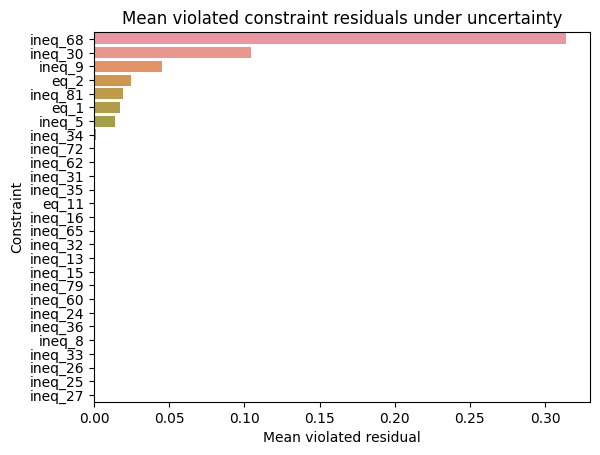

In [5]:
print("Plotting violated constraint means.")
# Get absolute values of violated constraint residuals
# Abs values before mean: be fair to eq constraints (either side of 0)
vio_means_series = samples[qois].abs().mean().sort_values(ascending=False)
vio_means = pd.DataFrame(vio_means_series, columns=["mean"])
vio_means["variable"] = vio_means.index
vio_means.reset_index(drop=True)

# Exclude objf and vio-constr_res
filter_qois = ["objf", "vio_constr_res"]
constrs_mask = ~vio_means["variable"].isin(filter_qois)
vio_means_filt = vio_means[constrs_mask]

# Plot
fig, ax = plt.subplots()
sns.barplot(data=vio_means_filt, x="mean", y="variable", ax=ax)
ax.set_title("Mean violated constraint residuals under uncertainty")
ax.set_xlabel("Mean violated residual")
ax.set_ylabel("Constraint")
fig.savefig("mean_vio_constr_res.png")

Most violated by frequency. Tricky to set a threshold: probably not the best.

Plotting constraint violation freqencies.


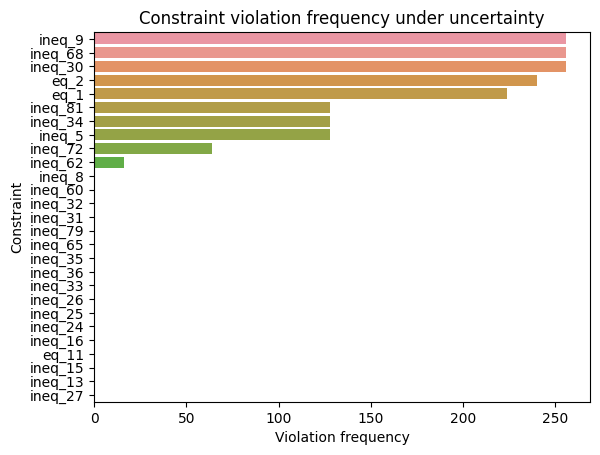

In [6]:
print("Plotting constraint violation freqencies.")
constr_tol = 1e-3
vio_counts = {}
for qoi in qois:
    # Count rows (samples) where each constraint is violated
    vio_count = samples[samples[qoi].abs() > constr_tol].shape[0]
    vio_counts[qoi] = vio_count

vio_counts
vio_counts_df = pd.DataFrame(data=vio_counts, index=[0])

vio_counts_df_melt = vio_counts_df.melt()
vio_counts_df_melt = vio_counts_df_melt.sort_values(by="value", ascending=False)
vio_counts_df_melt.reset_index(drop=True)
vio_counts_df_melt_filt = vio_counts_df_melt[~vio_counts_df_melt["variable"].isin(filter_qois)]

# # Plot
fig, ax = plt.subplots()
sns.barplot(data=vio_counts_df_melt_filt, x="value", y="variable", ax=ax)
ax.set_title("Constraint violation frequency under uncertainty")
ax.set_xlabel("Violation frequency")
ax.set_ylabel("Constraint")
fig.savefig("vio_constr_res_freq.png")

### Distribution of violated constraint residuals

Plotting distribution of violated constraint residuals.


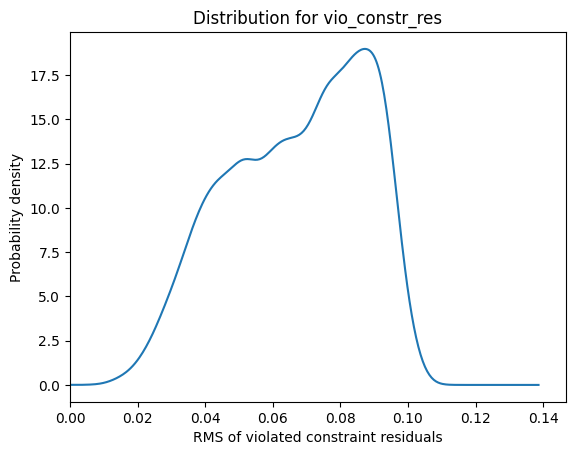

In [15]:
print("Plotting distribution of violated constraint residuals.")
# Analyse a single output variable, vio_constr_res
results = campaign.analyse(qoi_cols=["vio_constr_res"])

# Get its distribution
dist = results.get_distribution(qoi="vio_constr_res")

# Locations for density function to be evaluated
# (This is taken from easyvvuq's fusion tutorial)
x = np.linspace(dist.lower[0], dist.upper[0], num=500)
pdf = dist.pdf(x)

# Plot
fig, ax = plt.subplots()
sns.lineplot(x=x, y=pdf, markers=True, ax=ax)
ax.set_title("Distribution for vio_constr_res")
ax.set_xlabel("RMS of violated constraint residuals")
ax.set_ylabel("Probability density")
ax.set_xlim([0.0, None])
fig.savefig("vio_constr_res_dist.png")

### Distribution of individual constraint violations

Plotting top 3 violated constraint distributions


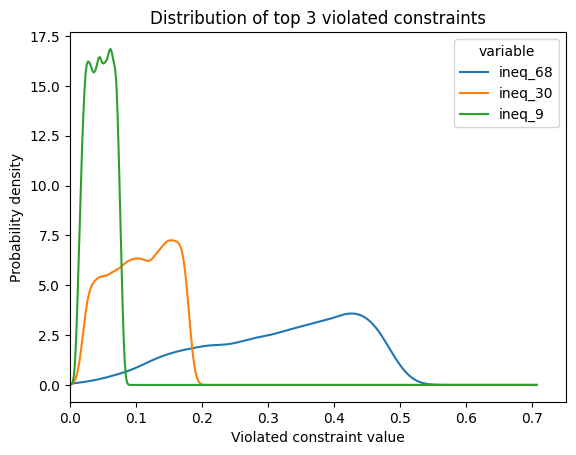

In [16]:
print("Plotting top 3 violated constraint distributions")
# Take top 3 violated contraints (by mean)
vio_means_filt = vio_means_filt.reset_index(drop=True)
top_vio_means = vio_means_filt[0:3]["variable"].to_list()

# Analyse a single output variable, vio_constr_res
results = campaign.analyse(qoi_cols=top_vio_means)

# Get the distributions
dists = []
dist_lowest = 0.0
dist_highest = 0.0
for qoi in top_vio_means:
    dist = results.get_distribution(qoi=qoi)
    if dist.lower[0] < dist_lowest:
        dist_lowest = dist.lower[0]
    if dist.upper[0] > dist_highest:
        dist_highest = dist.upper[0]
    dists.append(dist)

# Locations for density function to be evaluated
x = np.linspace(dist_lowest, dist_highest, num=500)

# Flip x to make +ve
pdfs = {"x": -x}
for constr_name, dist in zip(top_vio_means, dists):
    pdfs[constr_name] = dist.pdf(x)

top_vio_means_df = pd.DataFrame(pdfs)
top_vio_means_df
top_vio_means_df_melt = top_vio_means_df.melt(id_vars="x", value_vars=top_vio_means)
top_vio_means_df_melt
# Plot
fig, ax = plt.subplots()
sns.lineplot(data=top_vio_means_df_melt, x="x", y="value", hue="variable", markers=True, ax=ax)
ax.set_title("Distribution of top 3 violated constraints")
ax.set_xlabel("Violated constraint value")
ax.set_ylabel("Probability density")
ax.set_xlim([0.0, None])
fig.savefig("top_3_vio_constr_res_dist.png")

### Objective function

Plotting objective function distribution


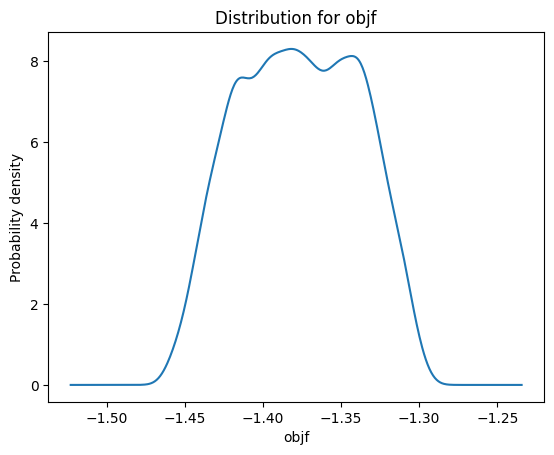

In [17]:
print("Plotting objective function distribution")
# Analyse a single output variable, vio_constr_res
results = campaign.analyse(qoi_cols=["objf"])

# Get its distribution
dist = results.get_distribution(qoi="objf")

# Locations for density function to be evaluated
x = np.linspace(dist.lower[0], dist.upper[0], num=500)
pdf = dist.pdf(x)

# Plot
fig, ax = plt.subplots()
sns.lineplot(x=x, y=pdf, markers=True, ax=ax)
ax.set_title("Distribution for objf")
ax.set_xlabel("objf")
ax.set_ylabel("Probability density")
fig.savefig("objf_dist.png")

## Sobol indices

### Violated constraint residuals

Sobols for violated constraint residuals.

Plotting Sobols for violated constraint residuals.


/home/jon/anaconda3/envs/feasibility-uq/lib/python3.10/site-packages/easyvvuq/analysis/results.py:417: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


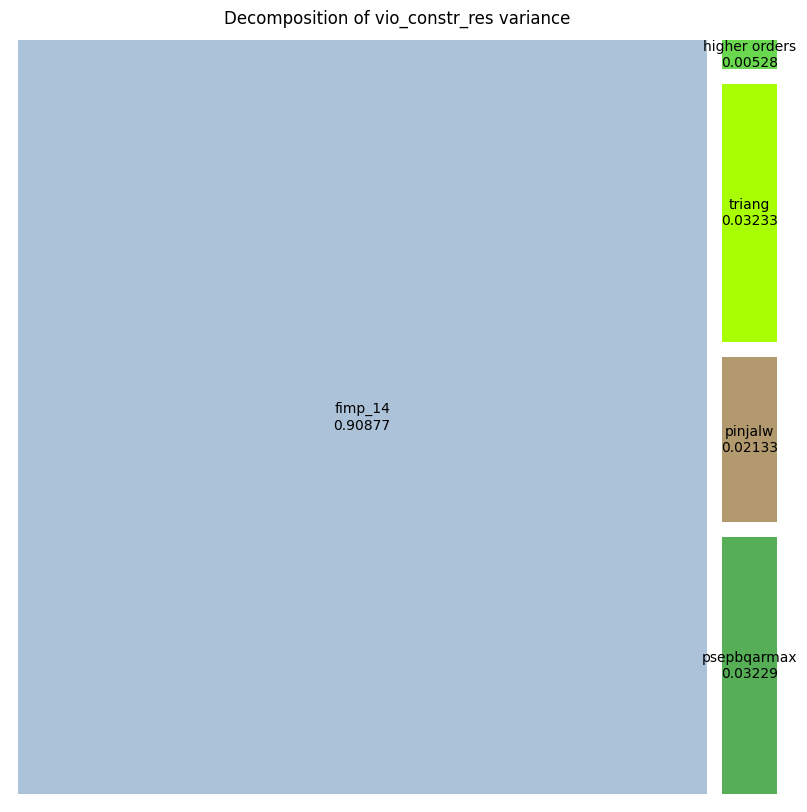

In [10]:
print("Plotting Sobols for violated constraint residuals.")
results = campaign.analyse(qoi_cols=["vio_constr_res"])
fig, ax = plt.subplots()
results.plot_sobols_treemap("vio_constr_res", figsize=(10, 10), ax=ax)
# ax.set_title("blah")
fig.savefig("vio_constr_res_sobols_treemap.png")

### Sobols for individual constraint

Interesting for discussion, but not for poster. Too much information (Sobol indices for each constraint).

Plotting individual constraint Sobols
Plotted ineq_68 Sobols.
Couldn't plot ineq_30 Sobols.
Plotted ineq_9 Sobols.


/home/jon/anaconda3/envs/feasibility-uq/lib/python3.10/site-packages/easyvvuq/analysis/results.py:417: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


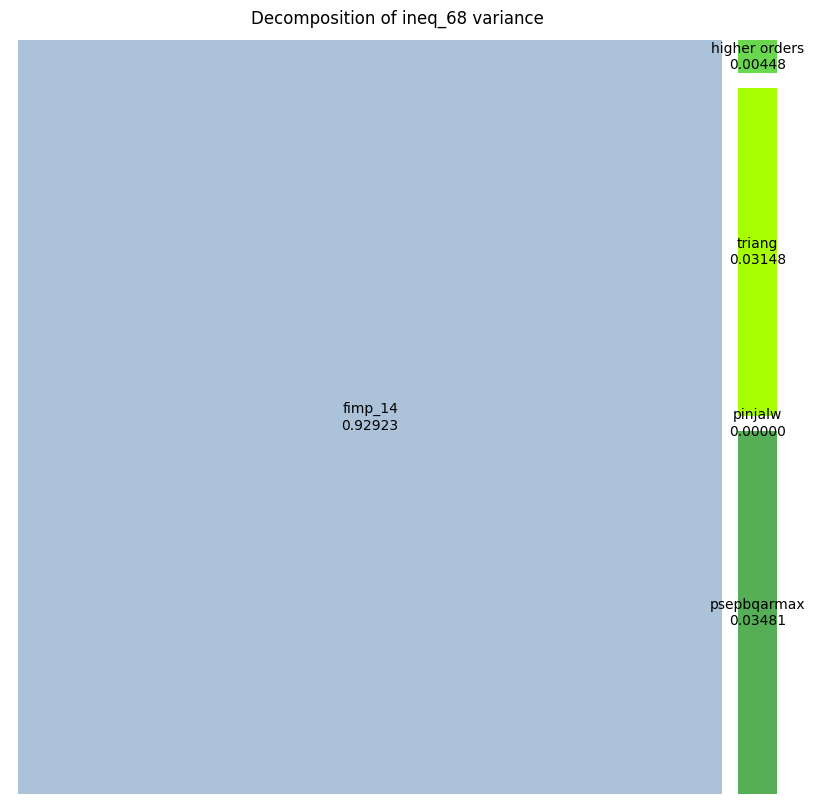

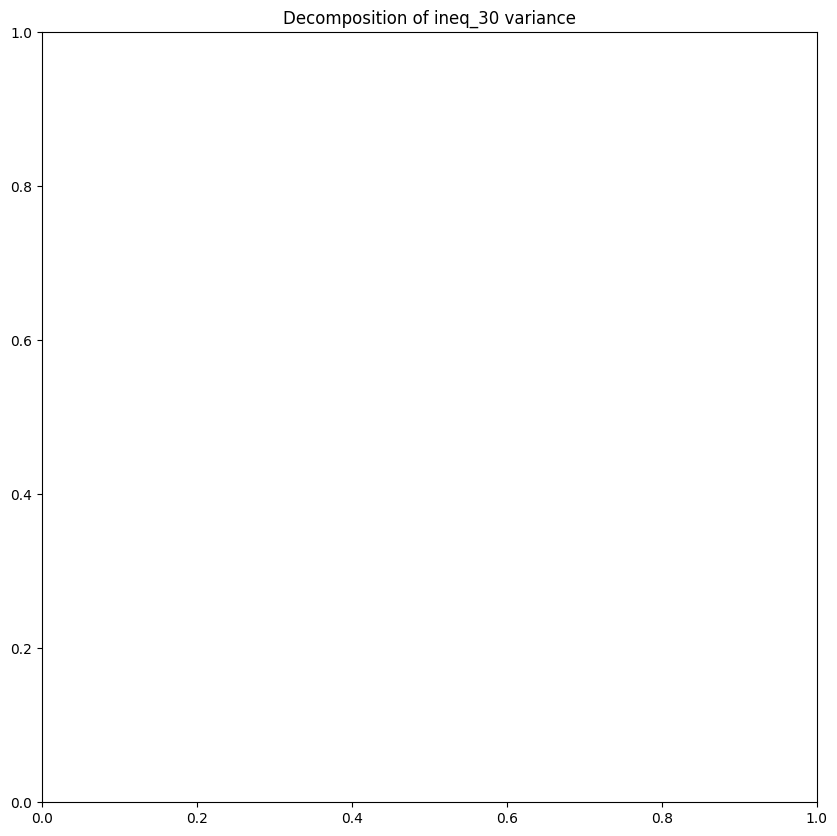

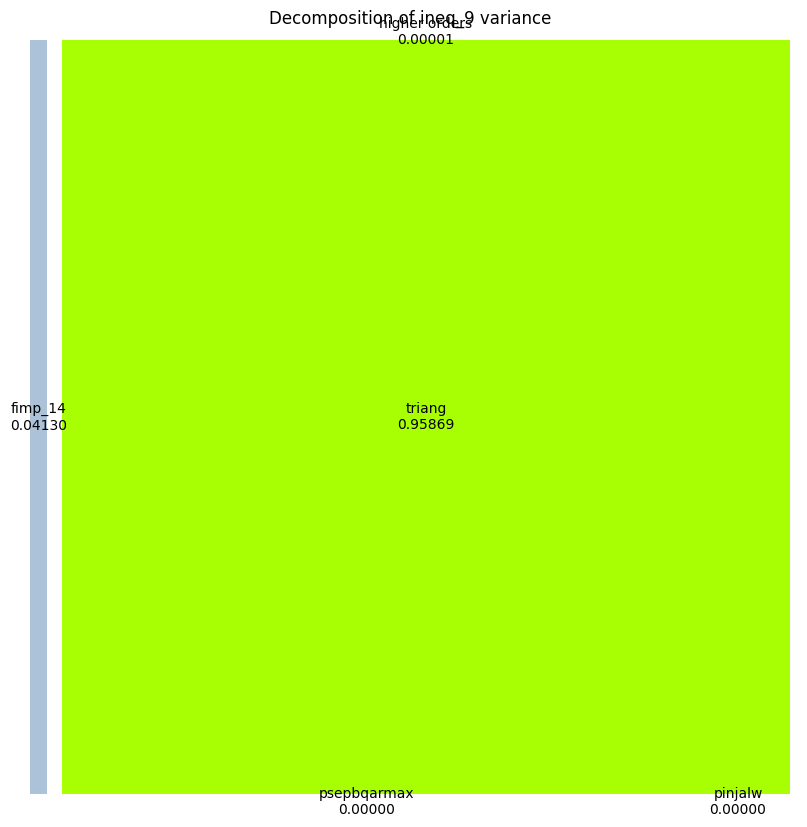

In [11]:
print("Plotting individual constraint Sobols")
results = campaign.analyse(qoi_cols=top_vio_means)
for constr_name in top_vio_means:
    fig, ax = plt.subplots()
    try:
        results.plot_sobols_treemap(constr_name, ax=ax)
        fig.savefig(f"{constr_name}_sobols_treemap.png")
        print(f"Plotted {constr_name} Sobols.")
    except:
        print(f"Couldn't plot {constr_name} Sobols.")
    

## Barplot of Sobol indices

Plotting barplot of Sobols for violated constraint residuals.


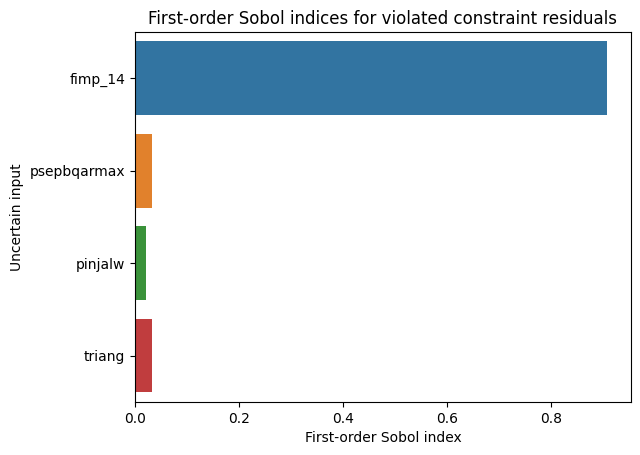

In [12]:
print("Plotting barplot of Sobols for violated constraint residuals.")
# results.sobols_first()
# results.sobols_second()
# results.sobols_total()

results = campaign.analyse(qoi_cols=["vio_constr_res"])
sobols_first = results.sobols_first()["vio_constr_res"]
sobols_first_df = pd.DataFrame(sobols_first)
sobols_first_df_melted = sobols_first_df.melt()
sobols_first_df_melted

fig, ax = plt.subplots()
sns.barplot(data=sobols_first_df_melted, x="value", y="variable", ax=ax)
ax.set_title("First-order Sobol indices for violated constraint residuals")
ax.set_xlabel("First-order Sobol index")
ax.set_ylabel("Uncertain input")
fig.savefig("fo_sobols_bar.png")

Plotting first and higher-order Sobols for violated constraint residuals.


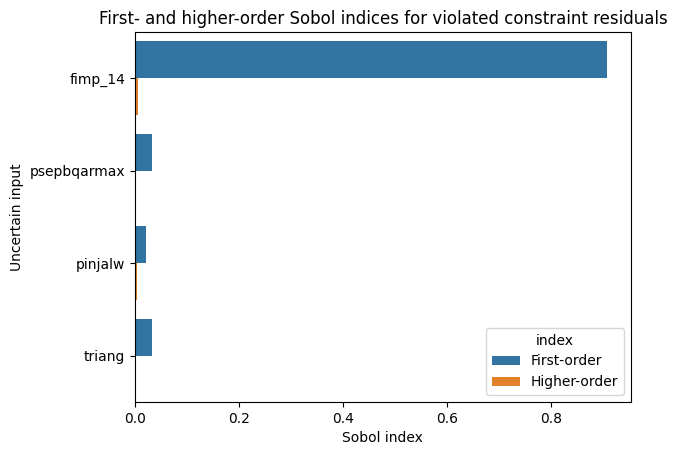

In [13]:
print("Plotting first and higher-order Sobols for violated constraint residuals.")
sobols_total = results.sobols_total()["vio_constr_res"]

# Calculate higher-order Sobol indices
sobols_higher = {}
for key in sobols_first:
    sobols_higher[key] = sobols_total[key] - sobols_first[key]

# Combine first and higher-order into df
sobols_first_and_higher = {}
for key in sobols_first:
    sobols_first_and_higher[key] = [sobols_first[key][0], sobols_higher[key][0]]

sobols_first_and_higher_df = pd.DataFrame(sobols_first_and_higher, index=["First-order", "Higher-order"])
sobols_first_and_higher_df = sobols_first_and_higher_df.reset_index()
sobols_first_and_higher_df
sobols_first_and_higher_df_melted = sobols_first_and_higher_df.melt(id_vars="index")
sobols_first_and_higher_df_melted

# Plot
fig, ax = plt.subplots()
ax = sns.barplot(data=sobols_first_and_higher_df_melted, x="value", y="variable", hue="index", orient="h")
ax.set_title("First- and higher-order Sobol indices for violated constraint residuals")
ax.set_xlabel("Sobol index")
ax.set_ylabel("Uncertain input")
fig.savefig("fo_ho_sobols_bar.png")